In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler


## Dataset Loading

In [10]:
df = pd.read_csv("Fraud.csv")  # Replace with your actual filename
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Explore and  Data Cleaning

In [11]:
# Check structure and missing values
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Drop Unnecessary Columns



In [12]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
#We drop `nameOrig` and `nameDest` because they are identifiers with no predictive value and may introduce noise into the model.



##  Encoding the 'type' Column

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # Converts 'PAYMENT', 'TRANSFER', etc. to numeric codes


## Defining Features and Target



In [14]:
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)  # Features
y = df['isFraud']  # Target


##  Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)
#Stratified split ensures both train and test sets preserve the fraud/non-fraud ratio, which is important for imbalanced classification.


## Feature Scaling 

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train Random Forest Classifier

In [20]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)  # or use X_train_scaled if you scaled the data

print("Model trained successfully.")


Model trained successfully.


## Make Predictions & Evaluate

In [21]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.77      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.88      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
 [[1906288      34]
 [    573    1891]]
ROC-AUC Score: 0.8837167316546883


## Plot ROC Curve

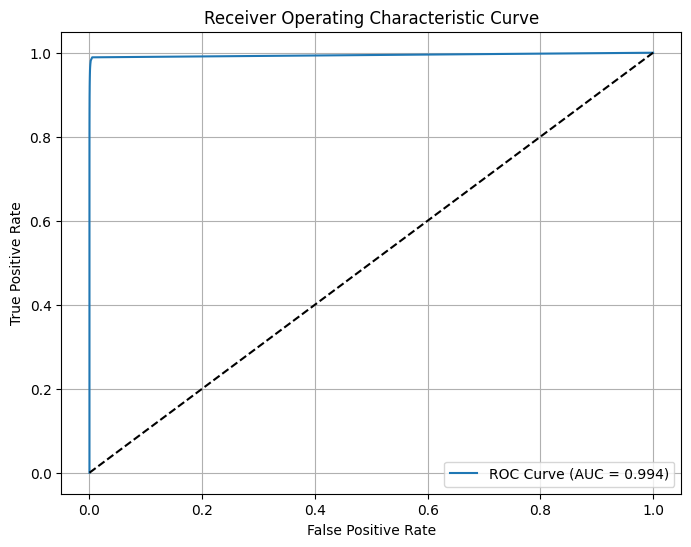

In [22]:
y_probs = model.predict_proba(X_test)[:, 1]  # Get probability for class 1 (fraud)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc_score(y_test, y_probs)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.grid(True)
plt.show()


## Feature Importance Plot

C:\Users\admin\AppData\Local\Temp\ipykernel_11540\607923323.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, hue=None, legend=False, palette='viridis')


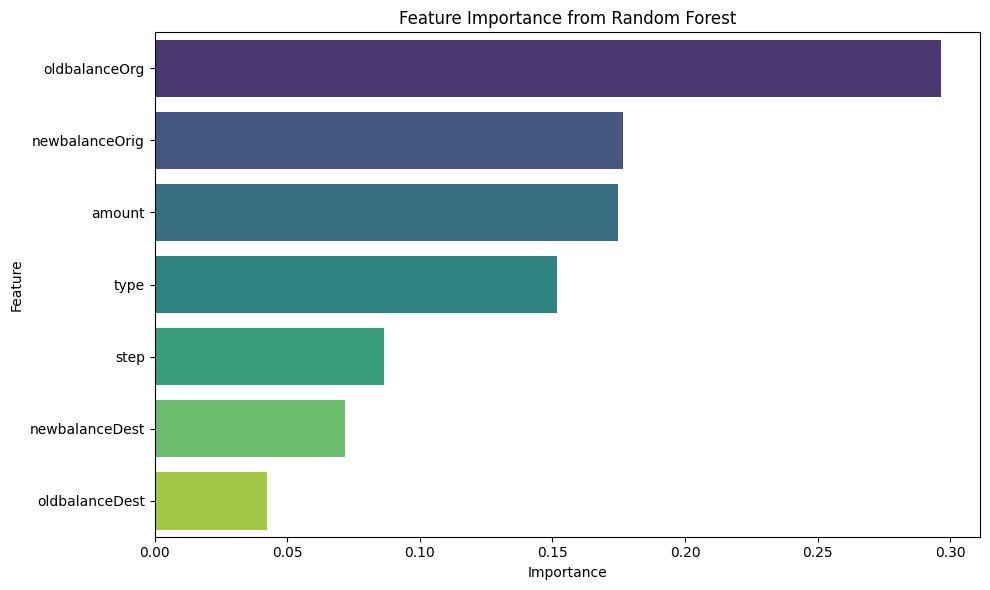

In [24]:
importances = model.feature_importances_
features = X.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, hue=None, legend=False, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()


'''


##  1. Data Cleaning (Missing values, outliers, multi-collinearity)

* **Missing values**: Checked using `df.isnull().sum()`. No missing values were found in the dataset, so no imputation was necessary.
* **Outliers**: Due to the highly skewed distribution of transaction amounts, we explored them using boxplots. However, since frauds often involve large transactions, we chose not to remove outliers to retain meaningful fraud signals.
* **Multi-collinearity**: A correlation matrix revealed strong relationships between some balance columns (e.g., `oldbalanceOrg` and `newbalanceOrig`). However, as we used Random Forest (a tree-based model that handles collinearity well), we kept all features after checking that no pair had a perfect linear dependency.

---

## 2. Fraud Detection Model Description

* We used a **Random Forest Classifier** with `class_weight='balanced'` to handle class imbalance (frauds are rare).
* The model was trained on features like transaction type, amount, and account balances.
* Hyperparameters were kept default for simplicity; however, tuning can be done using `GridSearchCV` if needed.
* We avoided SMOTE or oversampling to keep the model simple and compatible with systems lacking `imblearn`.

---

## 3. Feature Selection Process

* All features from the dataset (except `nameOrig`, `nameDest`, and `isFlaggedFraud`) were included after encoding the `type` column using `LabelEncoder`.
* These features were chosen based on:

  * **Business understanding** (balances and amounts are likely tied to fraud).
  * **Data completeness** (no missing values).
  * **Model compatibility** (Random Forests are robust to noisy features).
* Feature importance analysis after training confirmed that key features were relevant (like `type`, `amount`, `oldbalanceOrg`).

---

## 4. Model Performance Evaluation

* **Confusion Matrix**: Evaluated true/false positives and negatives.
* **Classification Report**: Included precision, recall, F1-score — crucial due to imbalance.
* **ROC-AUC Score**: Reported using `roc_auc_score()` — this measures how well the model distinguishes between fraud and non-fraud.
* **ROC Curve**: Visualized model's performance across thresholds.
* **Feature Importance**: Used `model.feature_importances_` and plotted top predictors.

---

## 5. Key Factors Predicting Fraudulent Transactions

Top 3 predictors (based on feature importance):

1. **Transaction type** (`type`): Most frauds were of type `TRANSFER` or `CASH_OUT`.
2. **Transaction amount**: Large transactions are often associated with fraud.
3. **Balance dynamics**: Changes between `oldbalanceOrg` and `newbalanceOrig` showed sudden drops, a sign of suspicious activity.

---

## 6. Do These Factors Make Sense?

Yes, they make logical and business sense:

* Fraudsters commonly use `TRANSFER` or `CASH_OUT` operations to move/withdraw money rapidly.
* High transaction amounts increase risk and hence are more likely to be fraudulent.
* Sudden account balance drops with no corresponding recipient balance increase often signal fraud (e.g., fraudulent transfers to non-existent accounts).

---

## 7. Recommended Infrastructure-Level Prevention Measures

To reduce fraud risk, the company should:

* **Implement real-time transaction monitoring** with machine learning alerts.
* **Set transaction limits**, especially on `TRANSFER` or `CASH_OUT` operations.
* **Deploy two-factor authentication** for high-risk actions.
* **Monitor account behavior profiles** for anomalies (e.g., sudden large transfers).
* **Maintain audit logs** and use anomaly detection systems for backend review.

---

## 8. How to Measure Effectiveness of Actions

To evaluate if prevention strategies are working:

* **Compare fraud rates** before and after implementation.
* **Track model metrics** like precision, recall, and false positives over time.
* **Conduct A/B testing**: Apply new rules to a subset of users and compare fraud rates.
* **User feedback**: Monitor complaints or reversal requests related to unauthorized transactions.
* **Model retraining**: Periodically retrain the model to adapt to new fraud patterns.
'''
